# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using weight matrices manually, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks. We will soon learn how to work with this module. But first, let's import all of the required packages.

Before proceeding with this running code cells in this notebook, please ensure you have followed the instructions [here](https://github.com/beginners-machine-learning-london/intro_to_machine_learning_with_pytorch/tree/master/setup). 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import helper
import matplotlib.pyplot as plt


We are now going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

> Our goal is to build a neural network that can take one of these images and predict the digit in the image. 

There are a few steps to follow to build and train the neural network. These are as follows:

1. Loading the dataset
2. Building the neural network
3. Training the neural network

# 1. Loading the dataset
## 1.1 Defining our transforms

We need to get our dataset but before doing so we need to define a set of transformations that can be applied to the dataset that we can pass to Pytorch's dataset downloader. This is provided through the `torchvision` package. 

PyTorch provides the tools to perform common image transformations and processing before passing them to your neural network as training data.
These transforms can be chained together using `transforms.Compose([list_of_transforms])`. 

> **Exercise**: Using the pytorch's [Compose](https://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Compose) and [Normalize](https://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Normalize) define a chain of transforms where we convert the images to tensors, then normalize them with the mean and standard deviation of 0.5. 
Assign the transform object to a variable called `transform` to be used when we're downloading our dataset.

When you are done, your code should follow the same format as the one below:

```python
>>> transform = transforms.Compose([transforms.CenterCrop(10), transforms.ToTensor()])
```

In the above example, we are defining a chain of transforms where our images are cropped at center with desired output size of 10px, then they are converted to tensors.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),  transforms.Normalize([0.5], [0.5])])

## 1.2. Downloading the MNIST Data

Pytorch ships with a set of packaged datasets to get you started with training models instantly. These are located on `torchvision.datasets` module. See the [documentation](https://pytorch.org/docs/stable/torchvision/datasets.html) for more information on all the available datasets.

For this workshop, we are going to download the MNIST dataset which consists of 50,000 images of handwritten drawings.

You will write the code below to download the dataset of images called [MNIST](http://yann.lecun.com/exdb/mnist/) while transforming the images to be suitable for training.

When downloading the data from Pytorch's datasets, it expects the chain of transform instructions to be passed in. You can download the MNIST data using `datasets.MNIST()` by passing in the following parameters:

- `download_dir` for example `"~/test/MNIST_data/"` - Where in your computer you would like the data to be downloaded to.
- `download= True` to indicate you would like pytorch to download this dataset for you from the Internet onto the `download_dir`.
- `train=True` to indicate you want to use this data for training. If you set this attribute to false, Pytorch grabs the data from the testing set when downloading from MNIST dataset. We will cover networking testing and validation in another workshop.
- `transform = transform` to load the transforms onto the downloaded object. This can then be passed to the dataloader which then takes care of **batching**, **transforming** and **shuffling** the data for us. All great endavours for making sure our data is as randomised as possible for our model training.

> **Exercise:** Use Pytorch's [documentation](https://pytorch.org/docs/stable/torchvision/datasets.html) and above instructions to download MNIST data to a directory of your choice. Ensure you are passing in your chain of transforms and asking Pytorch to download from the training dataset. Save your data to a variable called `trainset`.

In [ ]:
trainset = datasets.MNIST("~/test/MNIST_data/", download=True, train=True, transform=transform)

If you complete this step correctly, you should see the following output when you run the code cell below:

```
Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\Username/MNIST_data/ (Note: Yours will be different)
    Split: Train
```

In [ ]:
# Check to see if you have downloaded the dataset correctly
trainset

## 1.3. Loading the downloaded data into a dataloader

Final step of preparing the data is to load it onto a python generator so that you can feed the network in batches which improves the training speed. It also lets you shuffle the images each time you request the batch, making sure the training process is as randomised as possible to avoid possible **overfitting** to the data. What **overfitting** is and how we can avoid it further is covered in the future workshops. 

Pytorch provides a utlity module called `torch.utils.data.DataLoader()` which accepts your training dataset alongside a set of parameters on how to create the dataloader for you. The main parameters are `shuffle` and `batch_size`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again.

> **Exercise:** Use Pytorch's [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) and above instructions to load the MNIST dataset you have just downloaded onto the `dataloader` which will be a python generator that serves the data for us. Set the `batch_size` to `64` and `shuffle` to `true`.

In [6]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We have the training data loaded into `dataloader` and we make that an iterator with `iter(dataloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in dataloader:
    ## do things with images and labels
```

You'll notice we created the `dataloader` with a batch size of 64, and `shuffle=True`.  As a demosntration, run the code cells below which grabs the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [7]:
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Pytorch also allows us to convert an image loaded as a tensor on `dataloader` to image again. To do so, we first convert it to a numpy array with `numpy()`. Considering an image is a matrix of numbers with the size of 28x28, we can use `squeeze()` to remove all the information from the numpy array that is not necessary for plotting an image (number of images per batch, colour channel).

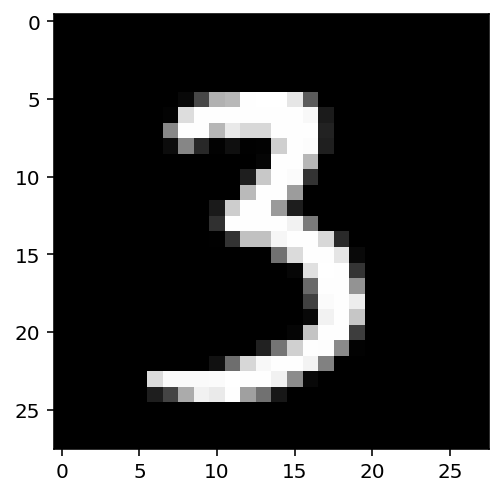

In [8]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

# 2. Building a Neural Network

PyTorch provides a module `nn` that makes building networks much simpler. Below we will see how we can create a neural network of our own with 784 inputs, 256 hidden units, 10 output units and a softmax output.

## 2.1 Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width="600px">

PyTorch provides a convenient way to build networks like the picture shown above where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). 

Here is an example from the documentation

```python
# Example of using Sequential
model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

```

In the above example, the network architecture is made out of convolutional layers (covered in future workshops) which take a long time to train on our CPUs and can be an overkill for our classification problem. The classification of handwritten digits is simple enough to use a linear network. You can create linear layers using `nn.Linear(no_input_node, no_output_nodes)`.

> **Exercise:** Create a network with **784 input units**, a hidden layer with **128 units and a ReLU activation**, then a hidden layer with **64 units and a ReLU activation**, and finally an output layer with **a softmax activation** as shown above. You can use a ReLU activation with the `nn.ReLU` module and softmax activation with `nn.Softmax(dim=1)`. 

In [9]:
from torch import nn
model = nn.Sequential(nn.Linear(784, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 10), nn.Softmax(dim = 1))

In [10]:
print(model.state_dict)

<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)>


If you complete the previous exercise correctly you should see the following output when you run the above code cells.
```
<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)>
```

## 2.2 Forward pass

Now that we have a network, let's see what happens when we pass in an image. The **forward pass** refers to calculation process of the values of the output layers from the inputs data. We can perform a forward pass through the network using `model.forward(image)`. 

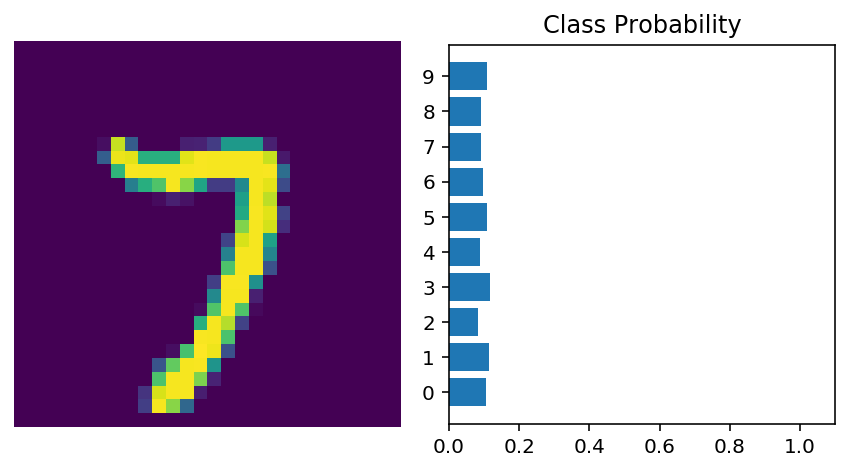

In [11]:
# Grab some data 
dataiter = iter(dataloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
probabilities = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), probabilities)

We'll now see how we can train a neural network to accurately predict the numbers appearing in the MNIST images.

# 3.Training Neural Networks

## 3.1 Overview of the Process

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width="500px">

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

The general process for training a neural network with PyTorch is as follows. Don't worry if you do not understand what each term means. We will cover them soon:

1. Make a forward pass through the network to get the network `output`
2. Use the network `output` to calculate the `loss` with the help of a `criterion`
3. Perform a backward pass through the network with `loss.backward()` to calculate the gradients
4. Take a step with Pytorch's `optimizer` to update the weights

We've already seen how to perform the first step. Let's see in the next section how `loss` can be calculated.

## 3.2 Gradient Descent

For our network to classify the images correctly, we need the right network parameters (the weights and biases in each layer). To find the network parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the network outputs.

By minimising this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width="350px">

## 3.2 Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the negative-log likelihood loss (`nn.NLLLoss`). You'll usually see the loss assigned to `criterion`. 


<img src='assets/nllloss.png' width="650px">

To actually calculate the loss, you first define the `criterion` then pass in the output of your network and the correct labels.

```python
raw_output = model.forward(images)
logits = torch.log(raw_output)
criterion = nn.NLLLoss()
loss = criterion(logits, labels)
```

This means we need to pass in the output of our network into the loss which is the log of the output of the softmax function. The log of the output of the network is usually called the **logits** or **scores**. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities and perform this log operation on our network's `raw_output` using `torch.log()`.


> **Exercise:** Define a negative log likelihood loss `criterion`

In [12]:
criterion = nn.NLLLoss()

In [13]:
print(type(criterion)) # <class 'torch.nn.modules.loss.NLLLoss'>

<class 'torch.nn.modules.loss.NLLLoss'>


## 3.3. Backpropagation (Backwardpass)

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one you've built above. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks. 

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we look at the process visually. Check out this [video](https://www.youtube.com/watch?v=Ilg3gGewQ5U) to learn more about backpropagation.

<img src='assets/backpropagation.png' width="800px">

## 3.4 Optimizer

One of the final pieces we need to start training is an optimizer that we'll use to update the weights with the gradients. The formula below shows that after calculating the gradients (change in error with respect to weights), we multiply them by a learning rate and then add them to the old weights to update the weights.

<img src='assets/weight_update_formula.png' width="350px">

We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use **stochastic gradient descent** with `optim.SGD` which is simply the algorithm being used to network the train in batches. There are ofcourse other algorithms for performing weight updates such as `Adam` which you can find more about in Pytorch's [documentation](https://pytorch.org/docs/stable/optim.html#algorithms). 

You can see how to define this optimizer in the code cell below.

In [14]:
from torch import optim

# Optimizers require the "network parameters" and a "learning rate" to optimize
# model.parameters() is a <generator object Module.parameters at 0x7f74ff4c4eb8>
# optim.SGD() Implements stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 3.5 Updating the network parameters

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

<img src='assets/weight_update_formula.png' width="350px">

Below we will see an example of calculating the gradients using a backwards pass. Let's see what our current weights are:

In [15]:
print('Initial weights - ', model[0].weight)

Initial weights -  Parameter containing:
tensor([[-0.0263, -0.0317, -0.0289,  ..., -0.0285,  0.0267,  0.0324],
        [ 0.0141,  0.0077,  0.0032,  ...,  0.0030,  0.0237,  0.0082],
        [ 0.0030,  0.0280,  0.0323,  ...,  0.0052, -0.0187, -0.0257],
        ...,
        [-0.0070, -0.0079, -0.0009,  ...,  0.0167,  0.0113,  0.0230],
        [-0.0352,  0.0119,  0.0123,  ..., -0.0327,  0.0181,  0.0342],
        [-0.0021,  0.0193,  0.0216,  ...,  0.0157, -0.0218, -0.0219]],
       requires_grad=True)


Let's go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [16]:
images, labels = next(iter(dataloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images) # output torch.Size([64, 10])
loss = criterion(torch.log(output), labels) # Scalar


In [17]:
print('Before backward pass: \n', model[0].weight.grad) # None

loss.backward()

print('After backward pass: \n', model[0].weight.grad) #torch.Size([128, 784]) - gradients for 128 hidden to 784 input nodes

Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.2696e-05,  3.2696e-05,  3.2696e-05,  ...,  3.2696e-05,
          3.2696e-05,  3.2696e-05],
        [-2.8328e-03, -2.8328e-03, -2.8328e-03,  ..., -2.8328e-03,
         -2.8328e-03, -2.8328e-03],
        [ 1.2917e-03,  1.2917e-03,  1.2917e-03,  ...,  1.2917e-03,
          1.2917e-03,  1.2917e-03],
        ...,
        [-4.6273e-03, -4.6273e-03, -4.6273e-03,  ..., -4.6273e-03,
         -4.6273e-03, -4.6273e-03],
        [-4.3167e-04, -4.3167e-04, -4.3167e-04,  ..., -4.3167e-04,
         -4.3167e-04, -4.3167e-04],
        [ 5.9487e-03,  5.9487e-03,  5.9487e-03,  ...,  5.9487e-03,
          5.9487e-03,  5.9487e-03]])


## 3.6 Training For Real
Now that we have a bit of understanding on how neural networks learn, let's implement it. Below I have provided you with with the code that trains the neural network and also have commented what each line of code does. Run the code cell below to see the network getting **trained**!! You will see the results of this training in a minute.

You should notice the training loss dropping in each iteration or `epoch`.

In [18]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in dataloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        # Resets the gradient step. If we don't do this, training loss actually increases per epoch
        optimizer.zero_grad() 
        # Do a forward pass for a batch
        output = model.forward(images) 
        # Check output vs target and Calculate the loss value (scalar) based on criteria
        loss = criterion(torch.log(output), labels) 
         # Calculate the gradients for each weight by doing a backward propogation
        loss.backward()
        # Update the weights based on the above calculated gradients multiplied by learning step
        optimizer.step() 
        # Return the value of the loss tensor (scalar) as a standard Python number and add to the variable running_loss
        running_loss += loss.item() # calculate the total loss by adding up all the losses for each batch
    else:
        # Divide the the total loss by number of items in the dataloader to get the average loss of the model
        print(f"Training loss: {running_loss/len(dataloader)}") # length of dataloader is 938 here

Training loss: 1.0383991086597382
Training loss: 0.3880856906109527
Training loss: 0.325760471549179
Training loss: 0.29123273488682216
Training loss: 0.2651539168266981


Now that we have a trained network, let's make a few **inferences**. Passing in 10 images to the trained network to see what it predicts. Run the code cells below to withness the magic of neural networks!

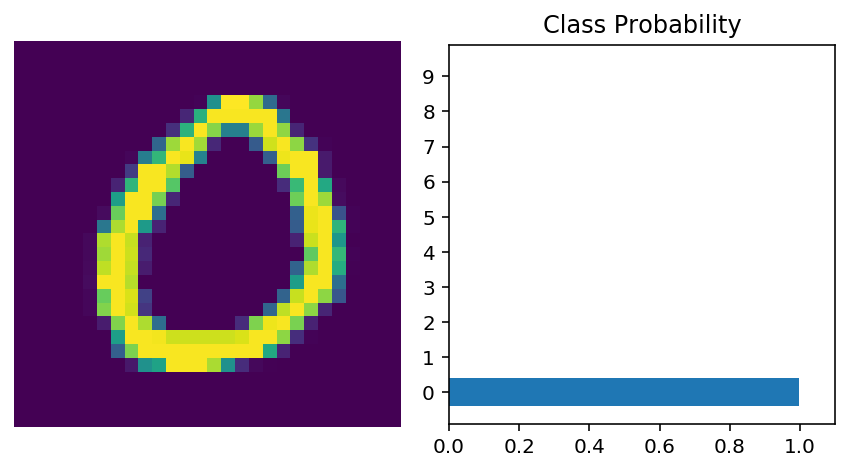

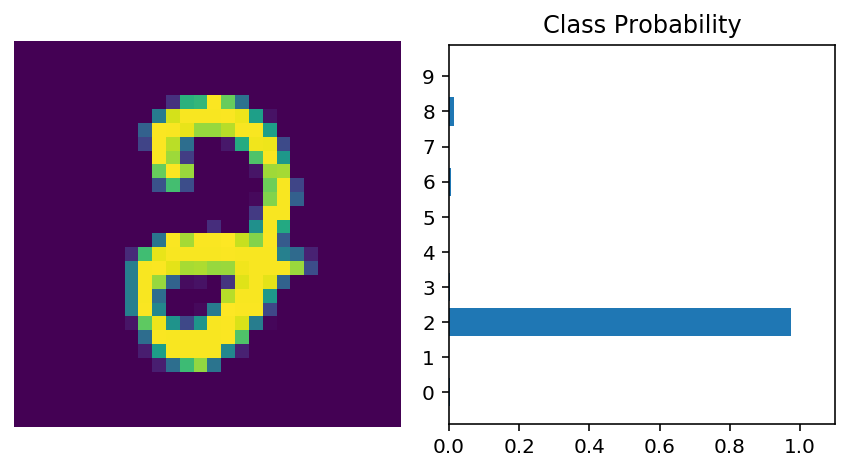

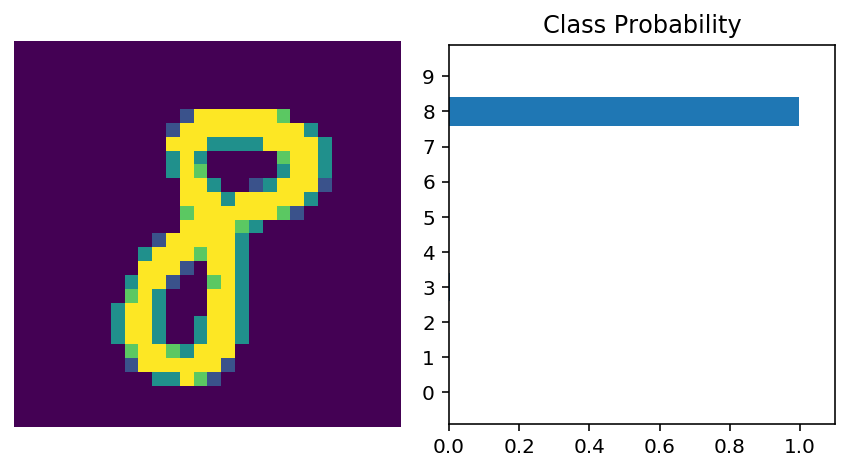

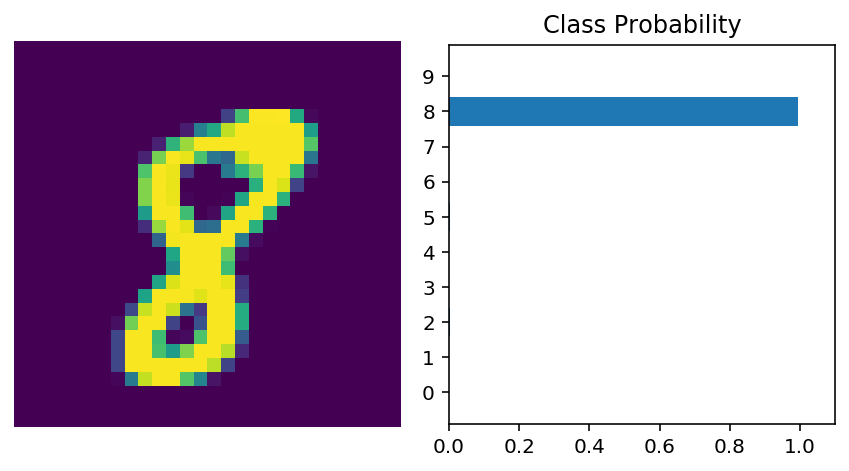

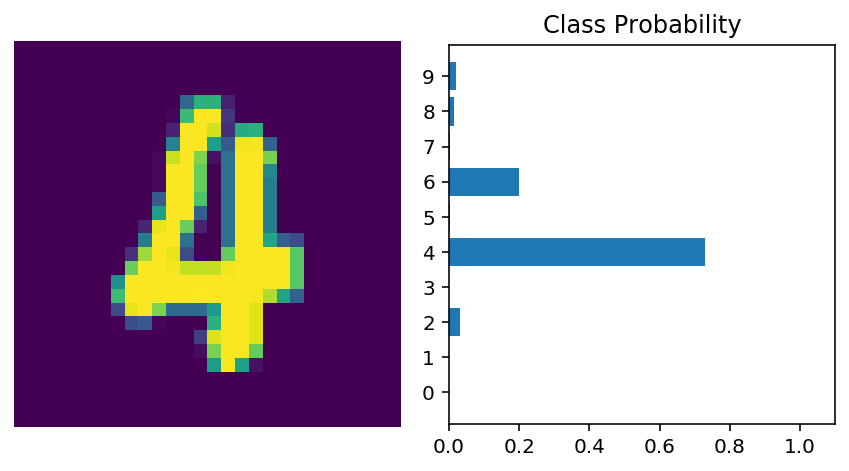

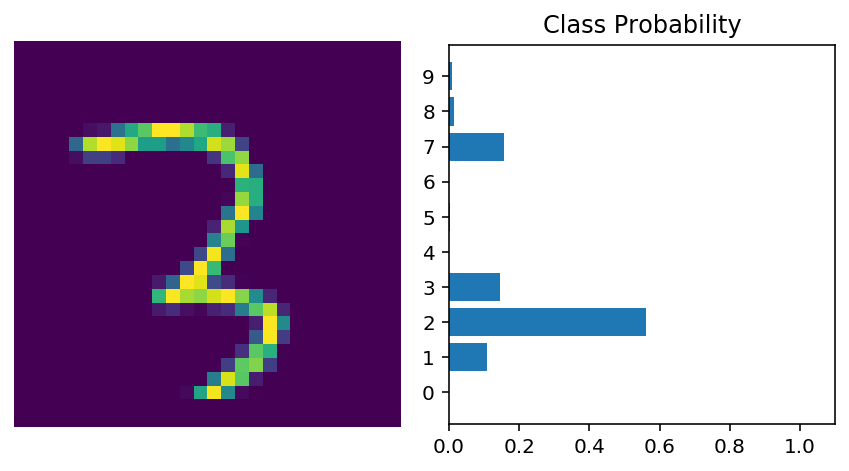

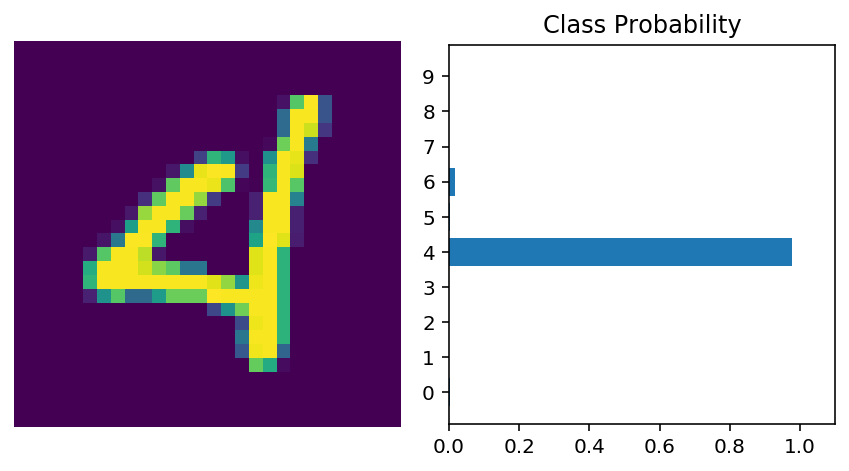

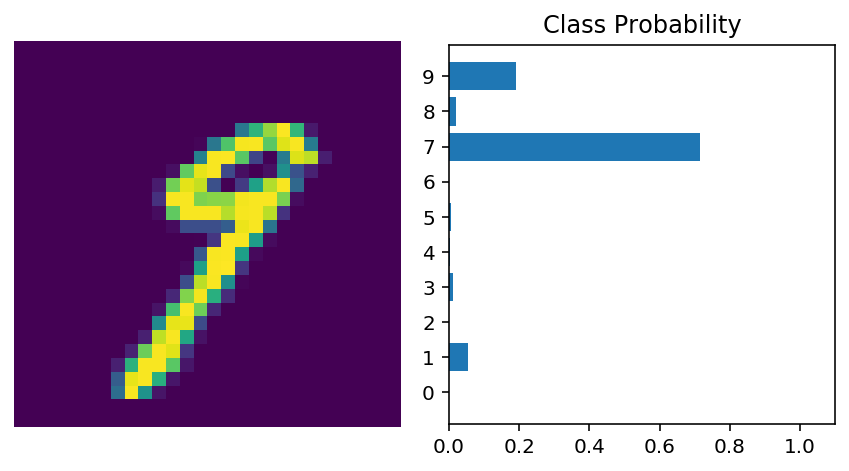

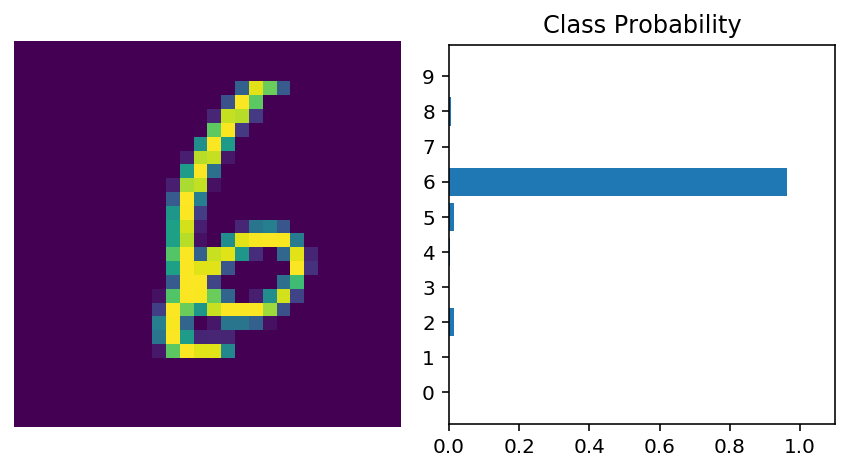

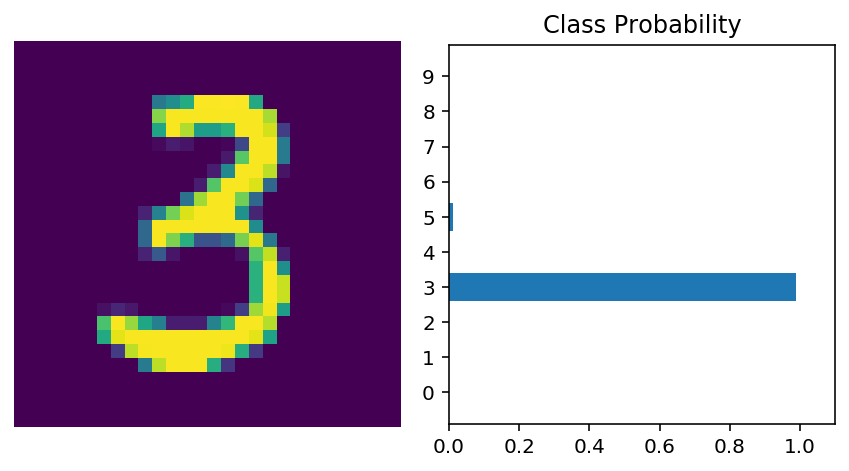

In [19]:
images, labels = next(iter(dataloader))

for i in range(10):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        ps = model.forward(img)

    helper.view_classify(img.view(1, 28, 28), ps)

# CONGRATULATIONS
Well done on compeleting the above assignments! This was a hard exercise and you have learned a lot about how neural networks work and how to work with Pytorch. We hope that you enjoyed this **Introduction to machine learnign with Pytorch Workshop**. To learn more about neural networks and deep learning check out a few resources we have provided in our repo's [README.md](https://github.com/beginners-machine-learning-london/intro_to_machine_learning_with_pytorch).

Also make sure to sign up on our meetup group to be informed of future workshops!
[London Beginners Machine Learnign Meetup](https://www.meetup.com/beginners-machine-learning-london/)